# ML model for language detection of a text document

**Dataset**: European Parliament Proceedings Parallel Corpus (EPPPC) 1996-2011 (Koehn 2005). 

**Languages**: English, Danish, German, Swedish and Italian.

**Approach**: Multiclass supervised classification based on TF-IDF weighted N-character-gram (Cavnar & Trenkle 1994) text representation.

**The source code**: put link

## 1. Import packages

In [1]:
import os
from pathlib import Path
import json
from bs4 import BeautifulSoup
import regex as re
import pandas as pd
from typing import List
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

## 2. Define functions

In [2]:
def get_files(rootdir: str) -> List[str]:
    """Collects paths to files across directories in a given rood directory. 
    Args:
        rootdir (str): The path to a root directory.
    Returns:
        List[str]: List with files paths.
    """

    files_paths = []

    for dir in os.listdir(rootdir):
        dir_path = os.path.join(rootdir, dir)
        for file in os.listdir(dir_path):
            file_path = os.path.join(dir_path, file)
            if os.path.isfile(file_path):
                files_paths.append(file_path)

    return files_paths


def remove_html_commands(text: str) -> str:
    """
    Cleans text from html tags.
    Args:
        text (str): The string to remove tags from.
    Returns:
        str: A string cleaned from html tags.
    """

    soup = BeautifulSoup(text, features="html.parser")

    for script in soup(["script", "style"]):
        script.extract()

    text = soup.get_text()

    lines = (line.strip() for line in text.splitlines())
    chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
    text = "\n".join(chunk for chunk in chunks if chunk)

    return text


def clean_text(text: str) -> str:
    """
    Cleans text from punctuation, URLs, ASCII charecters (except special letters, f.ex., German umlaut), 
    multiple spaces and lowercases.
    Args:
        text (str): The text document to clean.
    Returns:
        str: The cleaned document.
    """

    no_urls = re.sub(r"http\S+", "", text)
    no_special_ch = re.sub(r"([^A-Za-zØøÅåÆæÄäÖöÜüẞß])|(\w+:\/\/\S+)", " ", no_urls)
    no_special_ch = no_special_ch.replace("\n", " ")
    lowercased_str = no_special_ch.lower()
    cleaned_text = " ".join(lowercased_str.split())

    return cleaned_text

## 3. Build a corpus
Steps:

1. Scrap text documents from *.txt* files and preprocess (clean). 

   Note that stop words (articles, particles, pronouns, etc) are not removed since they are meaningful for the language detection task. 

   Furthermore, the texts in EPPPC corpus are considerably long. To avoid memory licks and long processing time, the documents length was restricted to 2000 characters.

2. Compose the list of dictionaries per language containing texts and language label. 
3. Save the resulting list to a *json* file (per language). 

   An example of a resulting json formated file:

```python
[
  },
  {
    "text": "fællesskabsfonden for tobak",
    "language": "da"
  },
  {
    "text": "økonomisk partnerskabsaftale ef landene i det østafrikanske fællesskab afstemning",
    "language": "da"
  },
]  
```

### 

In [4]:
root_dir = "data/"
paths = get_files(root_dir)

languages = ['/en/', '/da/', '/de/', '/sv/', '/it/']

dataset = [] 

for lang in languages:
    for file in paths:
        if lang in file:  
            lang_name = lang.replace('/', '')
            with open(file, encoding="utf-8") as f:
                text_label = {}
                data = f.readlines()
                data = " ".join(data)
                data = data[:2000]
                cleaned_doc = remove_html_commands(data)
                cleaned = clean_text(cleaned_doc)
                text_label["text"] = cleaned
                text_label["language"] = lang_name
            dataset.append(text_label)  
      
    data = json.dumps(dataset, ensure_ascii=False, indent=2)
    file_name = "json/" + lang_name + ".json"

    with open(file_name, "w") as outfile:
        outfile.write(data)
                
    dataset=[]

# 4.Combine json files into a dataframe
To have a single table with all collected samples, the data from 5 json files was merged into a pandas dataframe and saved into a *.pkl* file.

At this stage, the duplicated texts written in the same langauge as well as empty strings (which were the results of the cleaning perfomed on step 3) were removed.

The data was also tested with respect to the presence of text duplicates belonging to different languages. 

In [44]:
dfs = []

root_dir = "json/"
file_list = ["en.json", "sv.json", "de.json", "da.json", "it.json"]

for file in file_list:
    file_path = os.path.join(root_dir, file)
    with open(file_path) as f:
        df = pd.json_normalize(json.load(f))
        df = df.drop_duplicates(
            subset=["text"], keep="first"
        ).reset_index(drop=True)
        df = df[df['text'] != ""]
    dfs.append(df)

data_df = pd.concat(dfs, sort=False)
duplicated = data_df[data_df.duplicated()]
print(duplicated)
data_df.to_pickle("pkl/dataset.pkl")

Empty DataFrame
Columns: [text, language]
Index: []


# 5. Train an ML model
Steps:
1. Load *.pkl* file with the dataset. 

   Note: The total number of samples per language is shown below.

In [3]:
dataset = pd.read_pickle("pkl/dataset.pkl")
dataset.head()

,text,language
0,corrections to votes and voting intentions see...,en
1,community tobacco fund,en
2,ec eac partner states economic partnership agr...,en
3,the case of ai weiwei in china the next item i...,en
4,the cohesion policy after debate the next item...,en


In [4]:
dataset["language"].value_counts()

en    6569
da    6312
sv    6291
de    6146
it    4949
Name: language, dtype: int64

2. Save X (features) into a variable to use further as an input for TF-IDF vectorizer.
3. Transform Y (labels) categorical values into numeric once. 

In [5]:
docs = dataset["text"]

LE = LabelEncoder()
labels = LE.fit(dataset["language"])
name_mapping = dict(zip(LE.classes_, LE.transform(LE.classes_)))
labels = labels.transform(dataset["language"])
print(name_mapping)

{'da': 0, 'de': 1, 'en': 2, 'it': 3, 'sv': 4}


4. Split the data corpus into training and test sets.

In [6]:
x_train, x_test, y_train, y_test = train_test_split(docs, labels, test_size=0.20)

5. Define ML algorithim to use for model bulding. 

   For this multiclass classification task, the multinomial Naive Bayes classifier was chosen. 

6. Test various ```ngram_range``` parametrs for ```TfidfVectorizer()```. 

   To this end, the different combinations of unigrams, bigrams and trigrams were employed.

   To identify the best ```ngram_range```, the model performance was estimated with cross-validation method.

   F1 macro score was selected as the scoring parameter. 
   
   As a result, the highest mean and lowerst std F1-macro score values were obtained with trigrams.

   The results coinsicoincide with Cavnar, W., & Trenkle, J. (1994). N-gram-based text categorization. Proc. 3rd Symp. on Document Analysis and Information Retrieval (SDAIR-94) study. Cavnar, W., & Trenkle suggest that using trigrams (at the character
   level) generally yields the best results.

In [7]:
model = MultinomialNB()

n_gram_ranges = {"unigrams": (1,1), "uni_bi_grams": (1,2), "uni_tri_grams": (1,3), "bigrams": (2,2), "bi_tri_grams": (2,3), "trigrams":(3,3)}

for key, value in n_gram_ranges.items():

    tfidf_vectorizer = TfidfVectorizer(lowercase=False, analyzer="char", ngram_range=value)

    X_train = tfidf_vectorizer.fit_transform(x_train)
    X_test = tfidf_vectorizer.transform(x_test)

    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_macro')
    print("For", key, "the mean f1_macro score is", scores.mean(), "and the std f1_macro score is", scores.std())   

For unigrams the mean f1_macro score is 0.9556273854188451 and the std f1_macro score is 0.0021791265308955545
For uni_bi_grams the mean f1_macro score is 0.98822072069252 and the std f1_macro score is 0.0014319061745227493
For uni_tri_grams the mean f1_macro score is 0.9942607216687426 and the std f1_macro score is 0.0007358917434474549
For bigrams the mean f1_macro score is 0.9888058794063767 and the std f1_macro score is 0.0011604577877980344
For bi_tri_grams the mean f1_macro score is 0.9945227653284745 and the std f1_macro score is 0.0005970020094732383
For trigrams the mean f1_macro score is 0.9951105539930619 and the std f1_macro score is 0.0005009596597341769


7. Train the model on vocabualry of TF-IDF weighted n-grams.
8. Test the model on the test set.

In [8]:
tfidf_vectorizer = TfidfVectorizer(lowercase=False, analyzer="char", ngram_range=(3,3))

X_train = tfidf_vectorizer.fit_transform(x_train)
X_test = tfidf_vectorizer.transform(x_test)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 6. Model evaluation
9. Compute accuracy, precision, recall and F1-score.
10. Plot and save the confusion matrix.

Conclusion:

The scores are high because:
long texts
even though en and it, sv and da has overlaps in letters and words, the same combination of 3 char in those lang-s seems to be less common. 
It is monolingual approach which does not consider multilingual texts (f.,ex., mix of da and en).
This model also is not trained on all languages and especially those which are more similar to each other like Danish and Norwegian.

In [10]:
target_names = ["da", "de", "en", "it", "sv"]
report = classification_report(y_test, y_pred, target_names=target_names)
print(report)

              precision    recall  f1-score   support

          da       1.00      0.99      0.99      1283
          de       1.00      0.99      0.99      1221
          en       0.99      1.00      0.99      1299
          it       0.99      1.00      0.99       961
          sv       1.00      1.00      1.00      1290

    accuracy                           0.99      6054
   macro avg       0.99      0.99      0.99      6054
weighted avg       0.99      0.99      0.99      6054



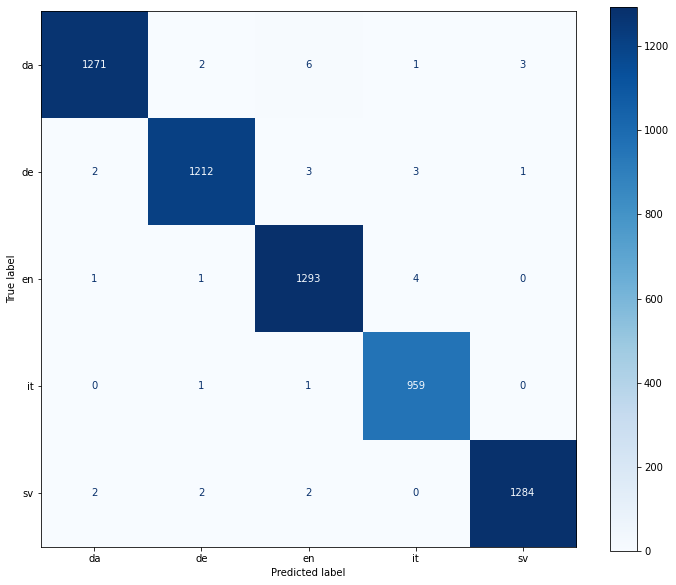

In [11]:
con_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12, 10))
cmd = ConfusionMatrixDisplay(con_matrix, display_labels=["da", "de", "en", "it", "sv"])
cmd.plot(ax=ax, cmap=plt.cm.Blues)
plt.savefig("figs/con_matrix.pdf")

# References
Cavnar William B., & Trenkle John M.1994. N-gram-based text categorization. *In Proceedings of the 3rd Annual Symposium on Document Analysis and Information Retrieval (SDAIR-94)*. 161–175. Las Vegas.

Koehn Philipp. 2005. Europarl: A Parallel Corpus for Statistical Machine Translation. *In Proceedings of Machine Translation Summit X: Papers*. 79–86. Phuket.